# Tokenization Complexity

Name: Almog Zemach

Contact: almog.zemach@post.runi.ac.il

Course: Seminar in Large Language Models and Information Theory (3968)

Supervise: Alon Kipnis

Description:

In this notebook, I explore several tokenization approaches and examine their impact on vocabulary size and token count. Specifically, I compare Byte Pair Encoding (BPE), WordPiece, and the LZW algorithm.

In [ ]:
!pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 1

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from datasets import load_dataset
from transformers import AutoTokenizer
from typing import List, Dict, Tuple, Optional
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tokenizers import Tokenizer
from tokenizers.models import BPE, WordPiece
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer, WordPieceTrainer

In [ ]:
dataset    = load_dataset("imdb")
train_texts = dataset["train"]["text"]
test_texts  = dataset["test"]["text"]

In [ ]:
def build_lzw_vocab(
    sentences: List[str],
    initial_dict_size: int = 256,
    max_dict_size: Optional[int] = None
) -> Tuple[Dict[str,int], Counter]:
    """
    Build a global LZW vocabulary over all sentences and count
    how often each phrase is emitted.

    Returns:
      - dictionary: mapping phrase → unique integer code
      - freq: Counter mapping each phrase → number of times it was output
    """
    dict_size = initial_dict_size
    dictionary = {chr(i): i for i in range(initial_dict_size)}
    freq = Counter()

    for text in sentences:
        w = ""
        for c in text:
            wc = w + c
            if wc in dictionary:
                w = wc
            else:
                # emit w
                if w in dictionary:
                    freq[w] += 1
                # add new phrase
                if max_dict_size is None or dict_size < max_dict_size:
                    dictionary[wc] = dict_size
                    dict_size += 1
                w = c
        # emit last w
        if w and w in dictionary:
            freq[w] += 1

    return dictionary, freq

In [ ]:
def prune_lzw_vocab(
    full_vocab: Dict[str,int],
    freq: Counter,
    max_vocab_size: int,
    min_freq: int = 1
) -> Dict[str,int]:
    """
    Prune an LZW vocabulary so that you keep:
      1) **all** single-character tokens,
      2) plus the most “relevant” multi-character tokens—
         i.e. those with freq >= min_freq,
         sorted by frequency (desc) then length (desc),
         until you hit max_vocab_size.

    Returns:
      A new dict mapping token → new contiguous ID [0..vocab_size-1].
    """
    single_chars = [tok for tok in full_vocab if len(tok) == 1]
    n_single = len(single_chars)
    if max_vocab_size < n_single:
        raise ValueError(
            f"max_vocab_size={max_vocab_size} < number of single-char tokens={n_single}"
        )

    multi = [
        tok for tok, code in full_vocab.items()
        if len(tok) > 1 and freq.get(tok, 0) >= min_freq
    ]

    multi.sort(key=lambda tok: (-freq[tok], -len(tok), full_vocab[tok]))

    slots_left = max_vocab_size - n_single - 1    # -1 due to <unk> token
    chosen_multi = multi[:slots_left]
    chosen_multi.append("<unk>")

    pruned_tokens = single_chars + chosen_multi
    new_vocab = {tok: idx for idx, tok in enumerate(pruned_tokens)}

    return new_vocab

In [ ]:
full_vocab, freq = build_lzw_vocab(train_texts)

vocab_5k = prune_lzw_vocab(full_vocab, freq, max_vocab_size=1000, min_freq=10)

print(f"Final vocab size: {len(vocab_5k)}  (slots: 256 single‐chars + {len(vocab_5k)-256} multi‐chars)")

In [ ]:
def lzw_toekn_encoding(text: str, vocab: Dict[str, int]) -> List[int]:
    """
    Encode `text` as a sequence of token IDs using a fixed LZW‐style vocab.
    Always picks the longest matching substring at each position.

    Args:
      text: the input string to tokenize.
      vocab: mapping from token string → integer ID

    Returns:
      List of integer token IDs.
    """
    max_token_len = max(len(tok) for tok in vocab)

    tokens: List[int] = []
    i = 0
    while i < len(text):
        match = None
        for L in range(max_token_len, 0, -1):
            substr = text[i : i + L]
            if substr in vocab:
                match = substr
                tokens.append(vocab[substr])
                i += L
                break

        if match is None:
            tokens.append(vocab["<unk>"])
            i += 1

    return tokens

In [ ]:
def compute_lzw_metrics(train_texts, test_texts, target_vocab):
    print("Compute LZW Metric, Vocab Size:", target_vocab)
    full_vocab, freq = build_lzw_vocab(train_texts)
    vocab = prune_lzw_vocab(full_vocab, freq, max_vocab_size=target_vocab, min_freq=10)

    vocab_size = len(vocab)

    def tokenize_lzw(text):
        return lzw_toekn_encoding(text, vocab)

    token_count = sum(len(tokenize_lzw(t)) for t in test_texts)
    return vocab_size, token_count

def compute_bpe_metrics(train_texts, test_texts, target_vocab):
    print("Compute BPE Metric, Vocab Size:", target_vocab)
    tok = AutoTokenizer.from_pretrained("gpt2")
    wf = defaultdict(int)
    for t in train_texts:
        words = [w for w,_ in tok.backend_tokenizer.pre_tokenizer.pre_tokenize_str(t)]
        for w in words:
            wf[w] += 1

    splits = {w: list(w) for w in wf}
    vocab  = set(c for w in wf for c in w)
    merges = {}
    while len(vocab) < target_vocab:
        pf = Counter()
        for w,f in wf.items():
            sp = splits[w]
            for i in range(len(sp)-1):
                pf[(sp[i],sp[i+1])] += f
        if not pf:
            break
        best = max(pf, key=pf.get)
        merges[best] = ''.join(best)
        for w in splits:
            seq = splits[w]
            i = 0
            while i < len(seq)-1:
                if (seq[i], seq[i+1]) == best:
                    seq[i:i+2] = [''.join(best)]
                else:
                    i += 1
            splits[w] = seq
        vocab.add(''.join(best))

    vocab_size = len(vocab)

    def tokenize_bpe(text):
        result = []
        words = [w for w,_ in tok.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)]
        for w in words:
            parts = list(w)
            for (a,b), m in merges.items():
                i = 0
                while i < len(parts)-1:
                    if (parts[i], parts[i+1]) == (a,b):
                        parts[i:i+2] = [m]
                    else:
                        i += 1
            result.extend(parts)
        return result

    token_count = sum(len(tokenize_bpe(t)) for t in test_texts)
    return vocab_size, token_count

def compute_wp_metrics(train_texts, test_texts, target_vocab):
    print("Compute WordPiece Metric, Vocab Size:", target_vocab)
    tok = AutoTokenizer.from_pretrained("bert-base-cased")
    wf = defaultdict(int)
    for t in train_texts:
        words = [w for w,_ in tok.backend_tokenizer.pre_tokenizer.pre_tokenize_str(t)]
        for w in words:
            wf[w] += 1

    splits = {w: [c if i==0 else '##'+c for i,c in enumerate(w)] for w in wf}
    vocab  = set(c for w in wf for c in w)
    merges = {}
    while len(vocab) < target_vocab:
        letter_counts = Counter()
        pair_counts = Counter()
        for w,f in wf.items():
            sp = splits[w]
            for i in range(len(sp)-1):
                pair_counts[(sp[i], sp[i+1])] += f
                letter_counts[sp[i]] += f
            letter_counts[sp[-1]] += f
        if not pair_counts:
            break
        best = max(
            pair_counts,
            key=lambda p: pair_counts[p] / (letter_counts[p[0]] * letter_counts[p[1]])
        )
        merged = best[0] + best[1].lstrip('##')
        merges[best] = merged
        for w in splits:
            seq = splits[w]
            i = 0
            while i < len(seq)-1:
                if (seq[i], seq[i+1]) == best:
                    seq[i:i+2] = [merged]
                else:
                    i += 1
            splits[w] = seq
        vocab.add(merged)

    vocab_size = len(vocab)

    def tokenize_wp(text):
        result = []
        words = [w for w,_ in tok.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)]
        for w in words:
            seq = [c if i==0 else '##'+c for i,c in enumerate(w)]
            for pair, m in merges.items():
                i = 0
                while i < len(seq)-1:
                    if (seq[i], seq[i+1]) == pair:
                        seq[i:i+2] = [m]
                    else:
                        i += 1
            result.extend(seq)
        return result

    token_count = sum(len(tokenize_wp(t)) for t in test_texts)
    return vocab_size, token_count

In [ ]:
def compute_bpe_metrics_fast(train_texts, test_texts, target_vocab):
    print("Compute BPE Metric, Vocab Size:", target_vocab)
    tok = Tokenizer(BPE(unk_token="[UNK]"))
    tok.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(vocab_size=target_vocab, special_tokens=["[UNK]"])
    tok.train_from_iterator(train_texts, trainer)

    vocab_size = tok.get_vocab_size()

    token_count = 0
    for encoding in tok.encode_batch(test_texts):
        token_count += len(encoding.tokens)

    return vocab_size, token_count


def compute_wp_metrics_fast(train_texts, test_texts, target_vocab):
    print("Compute WordPiece Metric, Vocab Size:", target_vocab)
    tok = Tokenizer(WordPiece(unk_token="[UNK]"))
    tok.pre_tokenizer = Whitespace()
    trainer = WordPieceTrainer(vocab_size=target_vocab, special_tokens=["[UNK]"])
    tok.train_from_iterator(train_texts, trainer)

    vocab_size = tok.get_vocab_size()

    token_count = 0
    for encoding in tok.encode_batch(test_texts):
        token_count += len(encoding.tokens)

    return vocab_size, token_count


In [ ]:
results = []
for name, fn in [
    ("LZW",       compute_lzw_metrics),
    ("BPE",       compute_bpe_metrics_fast),
    ("WordPiece", compute_wp_metrics_fast)
]:
    for vs in [1000, 5000, 10000, 20000]:
        vocab_size, tok_count = fn(train_texts, test_texts, vs)
        results.append({
            "Method":     name,
            "Target |V|": vs,
            "Actual |V|": vocab_size,
            "Test Token Count": tok_count
        })

# 6) Aggregate and display
df = pd.DataFrame(results)
print(df)
df.to_csv("imdb_train_vocab_test_token_metrics.csv", index=False)

Compute LZW Metric, Vocab Size: 1000
Compute LZW Metric, Vocab Size: 5000
Compute LZW Metric, Vocab Size: 10000
Compute LZW Metric, Vocab Size: 20000
Compute BPE Metric, Vocab Size: 1000
Compute BPE Metric, Vocab Size: 5000
Compute BPE Metric, Vocab Size: 10000
Compute BPE Metric, Vocab Size: 20000
Compute WordPiece Metric, Vocab Size: 1000
Compute WordPiece Metric, Vocab Size: 5000
Compute WordPiece Metric, Vocab Size: 10000
Compute WordPiece Metric, Vocab Size: 20000
       Method  Target |V|  Actual |V|  Test Token Count
0         LZW        1000        1000          15828149
1         LZW        5000        5000           9587960
2         LZW       10000       10000           7987856
3         LZW       20000       20000           6827416
4         BPE        1000        1000          11123535
5         BPE        5000        5000           8416508
6         BPE       10000       10000           7799768
7         BPE       20000       20000           7400237
8   WordPiece        1

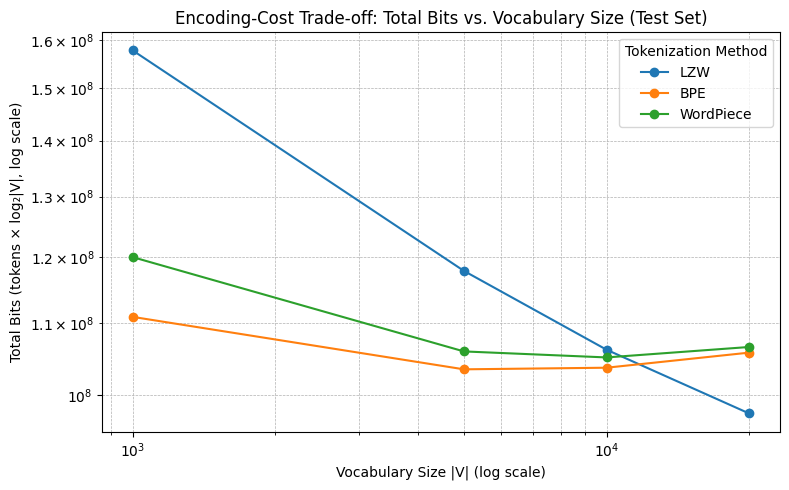

In [ ]:
# Compute total bits per row
df['Total Bits'] = df['Test Token Count'] * np.log2(df['Actual |V|'])

# Plot on log–log scales
plt.figure(figsize=(8,5))
for method in df['Method'].unique():
    sub = df[df['Method'] == method]
    plt.plot(sub['Actual |V|'], sub['Total Bits'], marker='o', label=method)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Vocabulary Size |V| (log scale)')
plt.ylabel('Total Bits (tokens × log₂|V|, log scale)')
plt.title('Encoding-Cost Trade-off: Total Bits vs. Vocabulary Size (Test Set)')
plt.legend(title="Tokenization Method")
plt.grid(which='both', ls='--', linewidth=0.5)
plt.tight_layout()
plt.show()


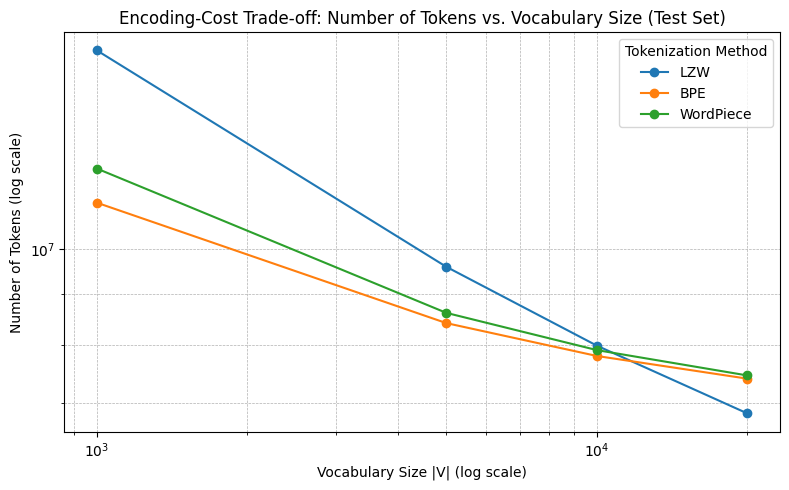

In [ ]:
plt.figure(figsize=(8,5))
for method in df['Method'].unique():
    sub = df[df['Method'] == method]
    plt.plot(sub['Actual |V|'], sub['Test Token Count'], marker='o', label=method)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Vocabulary Size |V| (log scale)')
plt.ylabel('Number of Tokens (log scale)')
plt.title('Encoding-Cost Trade-off: Number of Tokens vs. Vocabulary Size (Test Set)')
plt.legend(title="Tokenization Method")
plt.grid(which='both', ls='--', linewidth=0.5)
plt.tight_layout()
plt.show()
